<a href="https://colab.research.google.com/github/buyablemos/BitcoinClassifier/blob/main/UNIFIED_Bitcoin_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [62]:
!pip install torch torch-geometric kagglehub pandas scikit-learn -q

import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import SAGEConv, GATConv, GCNConv
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # dla konfiguracji multi-GPU

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używam urządzenia: {device}")

Używam urządzenia: cuda


# Pobieranie i preprocessing

In [47]:
dataset_path = kagglehub.dataset_download("ellipticco/elliptic-data-set")
base_path = f"{dataset_path}/elliptic_bitcoin_dataset"

df_features = pd.read_csv(f"{base_path}/elliptic_txs_features.csv", header=None)
df_classes = pd.read_csv(f"{base_path}/elliptic_txs_classes.csv")
df_edges = pd.read_csv(f"{base_path}/elliptic_txs_edgelist.csv")

feature_names = ['txId', 'time'] + [f'local_{i}' for i in range(1, 94)] + [f'agg_{i}' for i in range(1, 73)]
df_features.columns = feature_names
df_full = df_features.merge(df_classes, on='txId', how='left')

class_map = {'unknown': -1, '2': 0, '1': 1}
df_full['label_idx'] = df_full['class'].map(class_map)

nodes = df_full['txId'].values
node_map = {id: i for i, id in enumerate(nodes)}
df_edges['txId1'] = df_edges['txId1'].map(node_map)
df_edges['txId2'] = df_edges['txId2'].map(node_map)
df_edges = df_edges.dropna().astype(int)
edge_index = torch.tensor(df_edges[['txId1', 'txId2']].values.T, dtype=torch.long).to(device)

Using Colab cache for faster access to the 'elliptic-data-set' dataset.


# Cechy i Skalowanie

In [48]:
feature_cols = [c for c in df_full.columns if c.startswith('local_')]
X = df_full[feature_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

x = torch.tensor(X, dtype=torch.float).to(device)
y = torch.tensor(df_full['label_idx'].values, dtype=torch.long).to(device)
times = torch.tensor(df_full['time'].values, dtype=torch.long).to(device)

# Podział Train/Test (Split na kroku 40)


In [49]:
train_cutoff = 40
train_mask = (times <= train_cutoff) & (y != -1)
test_mask = (times > train_cutoff) & (y != -1)

# Wagi klas

In [50]:
y_train = y[train_mask]
count_0 = (y_train == 0).sum().float()
count_1 = (y_train == 1).sum().float()
weight_class_1 = count_0 / count_1
class_weights = torch.tensor([1.0, weight_class_1]).to(device)
loss_fn_cls = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"Train: {train_mask.sum().item()}, Test: {test_mask.sum().item()}")

Train: 36591, Test: 9973


# Augmentacja danych

In [64]:
train_idx = torch.where(train_mask)[0]
train_idx_0 = train_idx[(y[train_idx] == 0)]
train_idx_1 = train_idx[(y[train_idx] == 1)]

n0 = train_idx_0.numel()
n1 = train_idx_1.numel()

print(f"Przed augmentacją - Liczba 0 (Licit): {n0}, 1 (Illicit): {n1}")

num_to_add = 2*n1

# --- PROCES GENEROWANIA SZUMU / MIXUP ---
# Losujemy pary indeksów z klasy 1 (baza do tworzenia nowych przykładów)
idx_a = torch.randint(0, n1, (num_to_add,))
idx_b = torch.randint(0, n1, (num_to_add,))

node_a = train_idx_1[idx_a]
node_b = train_idx_1[idx_b]

# Współczynnik mieszania (lam) - ile cech bierzemy z którego węzła
# Dodajemy też mały szum Gaussa (std=0.02), żeby dane nie były zbyt idealne
lam = torch.rand((num_to_add, 1), device=x.device)
noise = torch.randn((num_to_add, x.size(1)), device=x.device) * 0.02

# Tworzymy nowe cechy: interpolacja między dwoma węzłami + szum
new_features = lam * x[node_a] + (1 - lam) * x[node_b] + noise
new_labels = torch.ones(num_to_add, dtype=torch.long, device=y.device)

# --- AKTUALIZACJA DANYCH ---
# Dodajemy nowe cechy do macierzy X i etykiety do Y
x_augmented = torch.cat([x, new_features], dim=0)
y_augmented = torch.cat([y, new_labels], dim=0)

# Tworzymy nowe indeksy dla tych sztucznych węzłów
new_indices = torch.arange(x.size(0), x.size(0) + num_to_add, device=y.device)
train_idx_aug = torch.cat([train_idx, new_indices], dim=0)

# Ważne: W grafach GNN nowe węzły potrzebują krawędzi!
# Najprostsza metoda: nowe węzły dziedziczą krawędzie po 'node_a'
row, col = edge_index
new_edges_list = []

for i, original_node in enumerate(node_a):
    # Znajdź sąsiadów oryginalnego węzła i przypisz ich do nowego
    mask = (row == original_node)
    if mask.any():
        new_edges = torch.stack([
            torch.full_like(col[mask], new_indices[i]),
            col[mask]
        ], dim=0)
        new_edges_list.append(new_edges)

edge_index_augmented = torch.cat([edge_index] + new_edges_list, dim=1).to(device)

print(f"Augmentacja zakończona. Dodano {num_to_add} syntetycznych węzłów klasy Illicit.")

# Teraz w treningu używasz: x_augmented, y_augmented, edge_index_augmented, train_idx_aug

Przed augmentacją - Liczba 0 (Licit): 32570, 1 (Illicit): 4021
Augmentacja zakończona. Dodano 8042 syntetycznych węzłów klasy Illicit.


# Wagi klas dla danych po augumentacji

In [65]:
new_n1=n1+num_to_add

weight_class_1_aug = n0 / new_n1
class_weights_aug = torch.tensor([1.0, weight_class_1_aug]).to(device)
loss_fn_cls_aug = torch.nn.CrossEntropyLoss(weight=class_weights_aug)

print(f"Liczba próbek klasy 1 po augumentacji: {new_n1}")
print(f"Nowa waga klasy 1 po augumentacji: {weight_class_1_aug:.4f}")

Liczba próbek klasy 1 po augumentacji: 12063
Nowa waga klasy 1 po augumentacji: 2.7000


# Definicje modeli

In [66]:
class NeuralNetwork(torch.nn.Module): # MLP
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, 256)
        self.bn1 = BatchNorm1d(256)
        self.lin2 = Linear(256, 128)
        self.bn2 = BatchNorm1d(128)
        self.lin3 = Linear(128, out_channels)

    def forward(self, x, edge_index=None):
        x = self.lin1(x)
        x = self.bn1(x).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin2(x)
        x = self.bn2(x).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin3(x)
        return x

class GraphSAGE(torch.nn.Module): # GNN
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphMAE(torch.nn.Module): # Advanced GNN
    def __init__(self, in_channels, hidden_channels, out_channels, mask_rate=0.5):
        super().__init__()
        self.mask_rate = mask_rate
        self.enc1 = GATConv(in_channels, hidden_channels, heads=4)
        self.enc2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.mask_token = torch.nn.Parameter(torch.zeros(1, in_channels))
        self.dec1 = torch.nn.Sequential(
            Linear(hidden_channels, hidden_channels), torch.nn.PReLU(),
            torch.nn.Dropout(0.2), Linear(hidden_channels, in_channels)
        )
        self.classifier = Linear(hidden_channels, out_channels)

    def mask_features(self, x):
        num_nodes = x.size(0)
        perm = torch.randperm(num_nodes, device=x.device)
        mask_idx = perm[:int(self.mask_rate * num_nodes)]
        x_masked = x.clone()
        x_masked[mask_idx] = self.mask_token
        return x_masked, mask_idx

    def forward_pretrain(self, x, edge_index):
        x_masked, mask_idx = self.mask_features(x)
        h = self.enc1(x_masked, edge_index).relu()
        h = self.enc2(h, edge_index).relu()
        return self.dec1(h), mask_idx

    def forward(self, x, edge_index): # forward_classify
        h = self.enc1(x, edge_index).relu()
        h = self.enc2(h, edge_index).relu()
        return self.classifier(h)
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)

        self.res_lin = Linear(in_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x0 = x

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = x + self.res_lin(x0)

        return self.lin(x)

class GCN(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()

        self.dropout = 0.3
        self.use_bn = True
        self.residual = True

        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.conv4 = GCNConv(128, 2)

        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(128)

    def forward(self, x, edge_index, return_emb: bool = False):
        h1 = self.conv1(x, edge_index)
        h1 = self.bn1(h1)
        h1 = F.relu(h1)
        h1 = F.dropout(h1, p=self.dropout, training=self.training)

        h2 = self.conv2(h1, edge_index)
        h2 = self.bn2(h2)
        h2 = F.relu(h2)
        h2 = F.dropout(h2, p=self.dropout, training=self.training)

        if self.residual:
            h2 = h1 + h2

        h3 = self.conv3(h2, edge_index)
        h3 = self.bn3(h3)
        h3 = F.relu(h3)
        h3 = F.dropout(h3, p=self.dropout, training=self.training)

        if self.residual:
            h3 = h2 + h3

        emb = h3

        out = self.conv4(emb, edge_index)

        return (out, emb) if return_emb else out

class MajorityClassifier(torch.nn.Module):
    def __init__(self, majority_class, num_classes=2):
        super().__init__()
        self.majority_class = majority_class
        self.num_classes = num_classes

    def forward(self, x, edge_index=None):
        # logits: bardzo duża wartość dla klasy większościowej
        logits = torch.zeros((x.size(0), self.num_classes), device=x.device)
        logits[:, self.majority_class] = 10.0
        return logits

class RandomClassifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, x, edge_index=None):
        # losowe logity
        return torch.rand((x.size(0), self.num_classes), device=x.device)


def sce_loss(x, y, alpha=3):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    return (1 - (x * y).sum(dim=-1)).pow(alpha).mean()

# Trening bez augmentacji

In [67]:
models_to_train = ["MLP", "GraphSAGE", "GraphMAE", "GraphGAT","GCN"]
results_log = []

for model_name in models_to_train:
    print(f"\n Trenowanie modelu: {model_name}")

    # Inicjalizacja modelu
    if model_name == "MLP":
        model = NeuralNetwork(x.shape[1], 128, 2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphSAGE":
        model = GraphSAGE(x.shape[1], 128, 2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphMAE":
        model = GraphMAE(x.shape[1], 64, 2).to(device)
        optimizer_pre = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer_fine = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphGAT":
        model = GAT(in_channels=x.shape[1], hidden_channels=64, out_channels=2,
                heads=8, dropout=0.3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GCN":
        model = GCN(x.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Trening
    if model_name == "GraphMAE":
        # Specyficzny trening dla MAE (Faza 1 + Faza 2)
        print("Faza 1: Pre-training (struktura)...")
        for epoch in range(400):
            model.train()
            optimizer_pre.zero_grad()
            x_recon, mask_idx = model.forward_pretrain(x, edge_index)
            loss = sce_loss(x_recon[mask_idx], x[mask_idx])
            loss.backward()
            optimizer_pre.step()

        print("Faza 2: Fine-tuning (klasyfikacja)...")
        for epoch in range(400):
            model.train()
            optimizer_fine.zero_grad()
            out = model(x, edge_index)
            loss = loss_fn_cls(out[train_mask], y[train_mask])
            loss.backward()
            optimizer_fine.step()
    else:
        # Standardowy trening dla MLP i SAGE
        print(" Standardowy trening...")
        for epoch in range(400):
            model.train()
            optimizer.zero_grad()
            out = model(x, edge_index)
            loss = loss_fn_cls(out[train_mask], y[train_mask])
            loss.backward()
            optimizer.step()

    # Ewaluacja

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)

        pred = out.argmax(dim=1)
        y_pred_np = pred[test_mask].cpu().numpy()

        probs = torch.softmax(out, dim=1)[:, 1]
        y_score_np = probs[test_mask].cpu().numpy()

        res = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_test_np, y_pred_np),
            "Illicit Precision": precision_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit Recall": recall_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit F1": f1_score(y_test_np, y_pred_np, pos_label=1)
        }

        results_log.append(res)
        print(f"> Zakończono. F1 (Illicit): {res['Illicit F1']:.4f}")


 Trenowanie modelu: MLP
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4058

 Trenowanie modelu: GraphSAGE
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4633

 Trenowanie modelu: GraphMAE
Faza 1: Pre-training (struktura)...
Faza 2: Fine-tuning (klasyfikacja)...
> Zakończono. F1 (Illicit): 0.4261

 Trenowanie modelu: GraphGAT
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4385

 Trenowanie modelu: GCN
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.3216


# Porównanie bez augmentacji

In [55]:
df_results = pd.DataFrame(results_log)
# Formatowanie tabeli
df_results = df_results.set_index("Model")
df_results = df_results.round(4)

print(df_results)

# Wskazanie zwycięzcy pod kątem F1 (dla klasy nielegalnej)
best_model = df_results['Illicit F1'].idxmax()
print(f"\n Najlepszy model (wg F1 Illicit): {best_model}")

           Accuracy  Illicit Precision  Illicit Recall  Illicit F1
Model                                                             
MLP          0.8993             0.2927          0.6469      0.4031
GraphSAGE    0.9262             0.3756          0.6107      0.4651
GraphMAE     0.9411             0.4541          0.5954      0.5153
GraphGAT     0.8795             0.2558          0.6775      0.3713
GCN          0.8490             0.2042          0.6469      0.3104

 Najlepszy model (wg F1 Illicit): GraphMAE


# Pętla treningnowa z augmentacją

In [56]:
models_to_train = [
    "Majority",
    "Random",
    "MLP",
    "GraphSAGE",
    "GraphMAE",
    "GraphGAT",
    "GCN"
]
results_log = []

# słownik na predykcje wszystkich modeli na zbiorze testowym
all_preds = {}
# y_true na zbiorze testowym (wspólne dla wszystkich modeli)
y_test_np = y[test_mask].cpu().numpy()


for model_name in models_to_train:
    print(f"\n Trenowanie modelu: {model_name}")

    # Inicjalizacja modelu
    if model_name == "MLP":
        model = NeuralNetwork(x.shape[1], 128, 2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphSAGE":
        model = GraphSAGE(x.shape[1], 128, 2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphMAE":
        model = GraphMAE(x.shape[1], 64, 2).to(device)
        optimizer_pre = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer_fine = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GraphGAT":
        model = GAT(in_channels=x.shape[1], hidden_channels=64, out_channels=2,
                heads=8, dropout=0.3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "GCN":
        model = GCN(x.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    elif model_name == "Majority":
        majority_class = int(np.bincount(y_train.cpu()).argmax())
        model = MajorityClassifier(majority_class).to(device)
    elif model_name == "Random":
        model = RandomClassifier().to(device)

    # Trening
    if model_name == "GraphMAE":
        # Specyficzny trening dla MAE (Faza 1 + Faza 2)
        print("Faza 1: Pre-training (struktura)...")
        for epoch in range(400):
            model.train()
            optimizer_pre.zero_grad()
            x_recon, mask_idx = model.forward_pretrain(x_augmented, edge_index_augmented)
            loss = sce_loss(x_recon[mask_idx], x_augmented[mask_idx])
            loss.backward()
            optimizer_pre.step()

        print("Faza 2: Fine-tuning (klasyfikacja)...")
        for epoch in range(400):
            model.train()
            optimizer_fine.zero_grad()
            out = model(x_augmented, edge_index_augmented)
            loss = loss_fn_cls_aug(out[train_idx_aug], y_augmented[train_idx_aug])
            loss.backward()
            optimizer_fine.step()
    elif model_name in ["Majority", "Random"]:
        print(" Brak treningu (baseline)")
        pass
    else:
        # Standardowy trening dla MLP i SAGE
        print(" Standardowy trening...")
        for epoch in range(400):
            model.train()
            optimizer.zero_grad()
            out = model(x_augmented, edge_index_augmented)
            loss = loss_fn_cls_aug(out[train_idx_aug], y_augmented[train_idx_aug])
            loss.backward()
            optimizer.step()

    # Ewaluacja

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)

        # decyzja klasowa
        pred = out.argmax(dim=1)
        y_pred_np = pred[test_mask].cpu().numpy()

        # P(klasa=1) -> ROC / PR
        probs = torch.softmax(out, dim=1)[:, 1]
        y_score_np = probs[test_mask].cpu().numpy()

        # zapisz oba
        all_preds[model_name] = {
            "y_pred": y_pred_np,
            "y_score": y_score_np
        }

        res = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_test_np, y_pred_np),
            "Illicit Precision": precision_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit Recall": recall_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit F1": f1_score(y_test_np, y_pred_np, pos_label=1)
        }

        results_log.append(res)
        print(f"> Zakończono. F1 (Illicit): {res['Illicit F1']:.4f}")


 Trenowanie modelu: Majority
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.0000

 Trenowanie modelu: Random
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.0985

 Trenowanie modelu: MLP
 Standardowy trening...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


> Zakończono. F1 (Illicit): 0.4906

 Trenowanie modelu: GraphSAGE
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4934

 Trenowanie modelu: GraphMAE
Faza 1: Pre-training (struktura)...
Faza 2: Fine-tuning (klasyfikacja)...
> Zakończono. F1 (Illicit): 0.4804

 Trenowanie modelu: GraphGAT
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.3806

 Trenowanie modelu: GCN
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.3259


# Porównanie z augmentacją

In [57]:
df_results = pd.DataFrame(results_log)
# Formatowanie tabeli
df_results = df_results.set_index("Model")
df_results = df_results.round(4)

print(df_results)

# Wskazanie zwycięzcy pod kątem F1 (dla klasy nielegalnej)
best_model = df_results['Illicit F1'].idxmax()
print(f"\n Najlepszy model (wg F1 Illicit): {best_model}")

           Accuracy  Illicit Precision  Illicit Recall  Illicit F1
Model                                                             
Majority     0.9475             0.0000          0.0000      0.0000
Random       0.5026             0.0544          0.5172      0.0985
MLP          0.9319             0.4042          0.6240      0.4906
GraphSAGE    0.9343             0.4148          0.6088      0.4934
GraphMAE     0.9336             0.4080          0.5840      0.4804
GraphGAT     0.8809             0.2618          0.6966      0.3806
GCN          0.8764             0.2284          0.5687      0.3259

 Najlepszy model (wg F1 Illicit): GraphSAGE


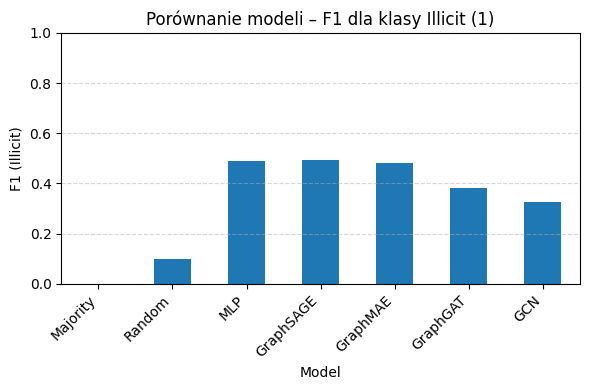

In [58]:
# === Wykres słupkowy F1 dla klasy 1 (Illicit) ===
plt.figure(figsize=(6, 4))
df_results["Illicit F1"].plot(kind="bar")
plt.title("Porównanie modeli – F1 dla klasy Illicit (1)")
plt.ylabel("F1 (Illicit)")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

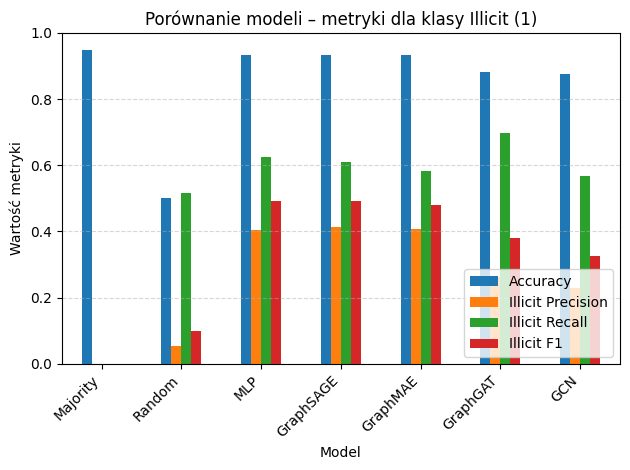

In [59]:
# === Wykres zbiorczy kilku metryk ===
metrics_to_plot = ["Accuracy", "Illicit Precision", "Illicit Recall", "Illicit F1"]

plt.figure(figsize=(8, 5))
df_results[metrics_to_plot].plot(kind="bar")
plt.title("Porównanie modeli – metryki dla klasy Illicit (1)")
plt.ylabel("Wartość metryki")
plt.ylim(0.0, 1.0)

plt.xticks(rotation=45, ha="right")

plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

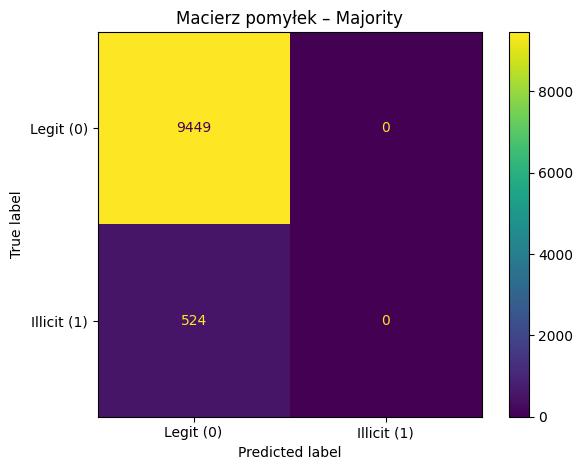

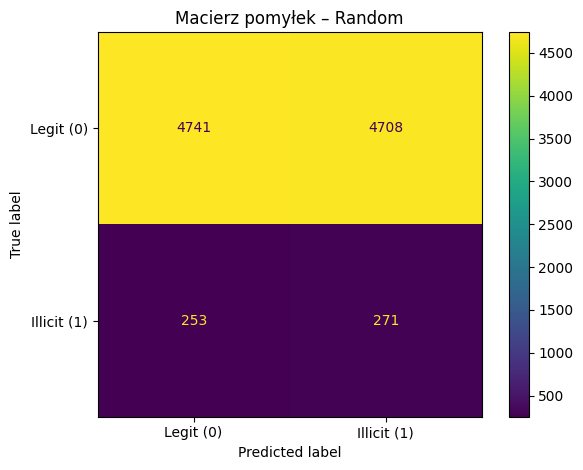

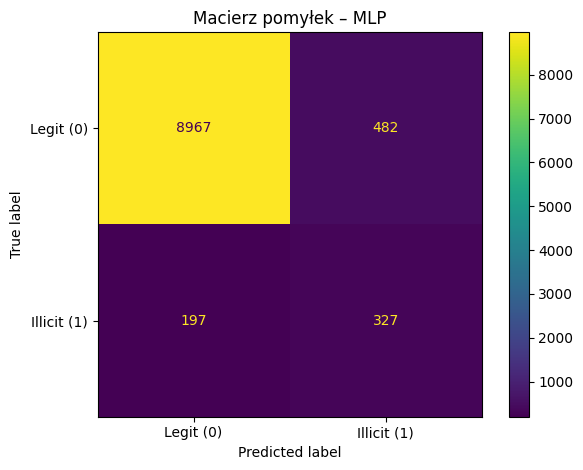

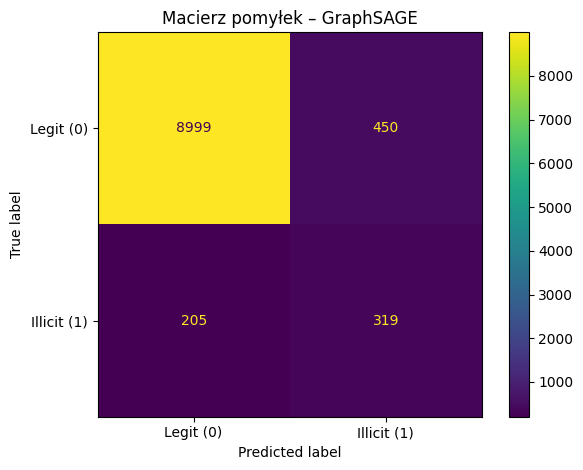

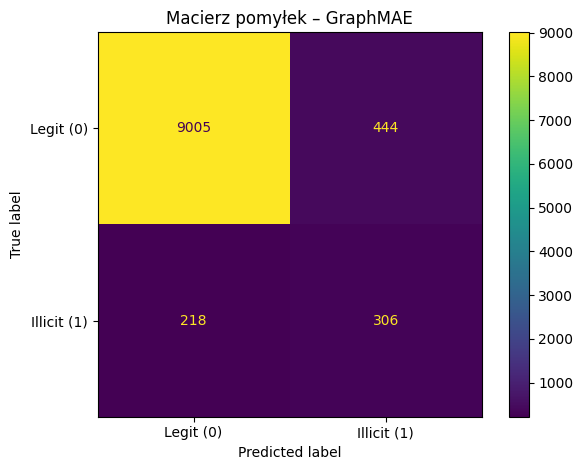

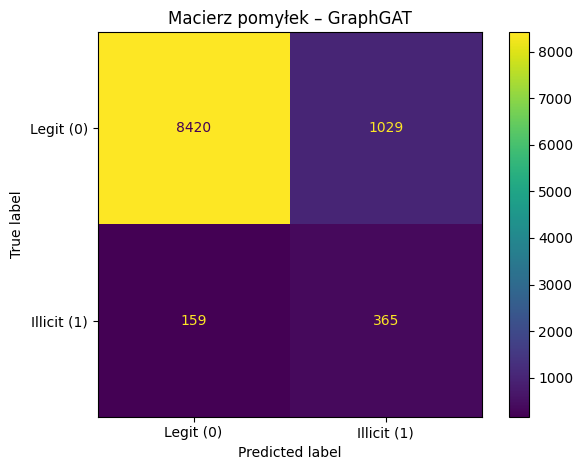

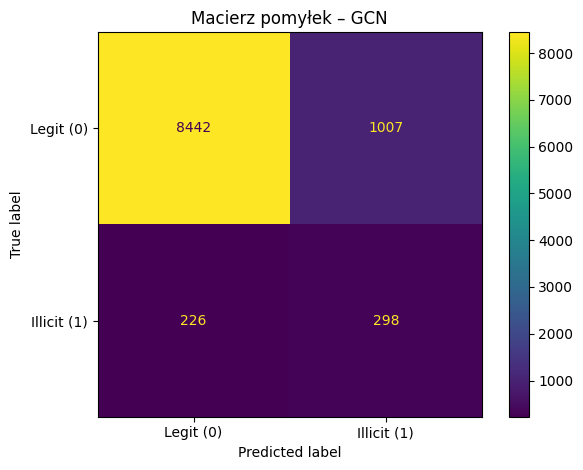

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for model_name in df_results.index:
    data = all_preds[model_name]
    y_pred_np = data["y_pred"]

    cm = confusion_matrix(y_test_np, y_pred_np, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Legit (0)", "Illicit (1)"]
    )
    disp.plot(values_format="d")
    plt.title(f"Macierz pomyłek – {model_name}")
    plt.tight_layout()
    plt.show()

# Wizualizacja wyników

## ROC Curve

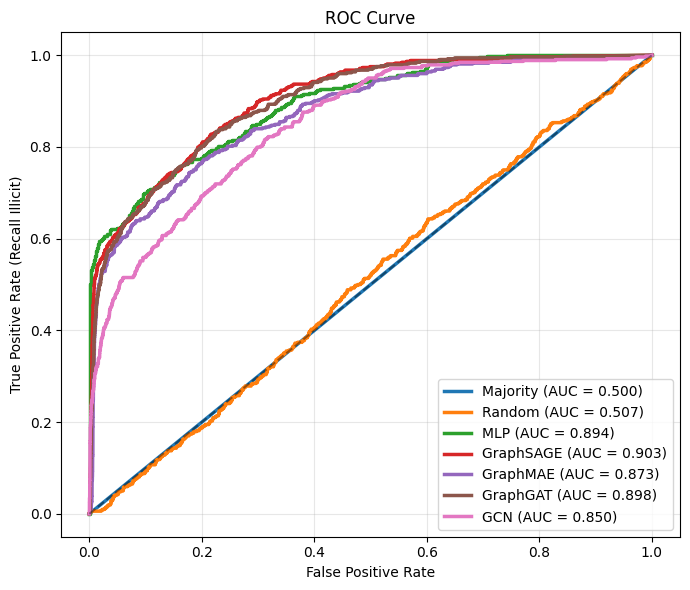

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

for model_name, data in all_preds.items():
    y_score = data["y_score"]   # P(Illicit = 1)

    fpr, tpr, _ = roc_curve(y_test_np, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr,
        linewidth=2.5,
        label=f"{model_name} (AUC = {roc_auc:.3f})"
    )

# linia losowa
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall Illicit)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Precision–Recall Curve